## Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import cv2
import pickle
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Randomize our input.
permutation = np.random.permutation(len(train['features']))
X_train, train_labels = train['features'][permutation], train['labels'][permutation]
permutation = np.random.permutation(len(test['features']))
X_test, y_test = test['features'][permutation], test['labels'][permutation]

# Get Sign Names
sign_names = []
with open('signnames.csv', 'r') as f:
    is_header = True
    for line in f:
        if is_header:
            is_header = False
        else:
            sign_names.append(line.split(",")[1])

In [2]:
### To start off let's do a basic data summary.

n_train = len(X_train)

n_test = len(X_test)

image_shape = X_train.shape[1:4]

n_classes = np.unique(np.concatenate((train_labels, y_test))).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


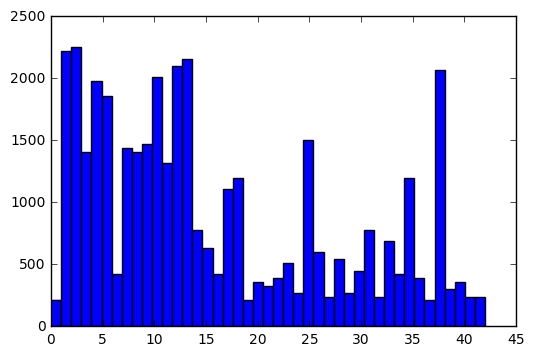

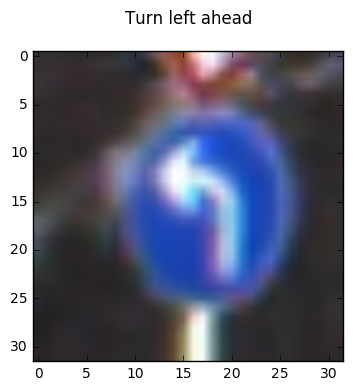

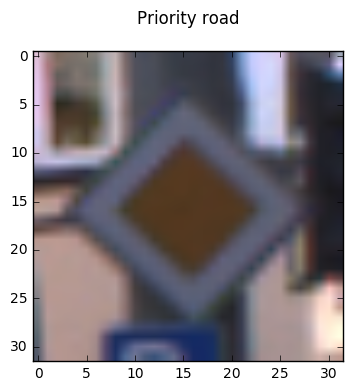

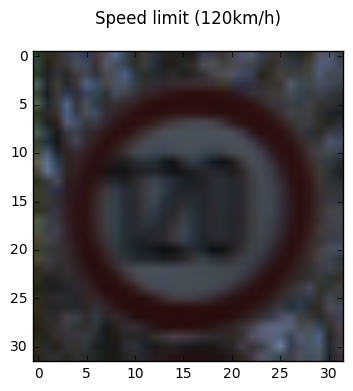

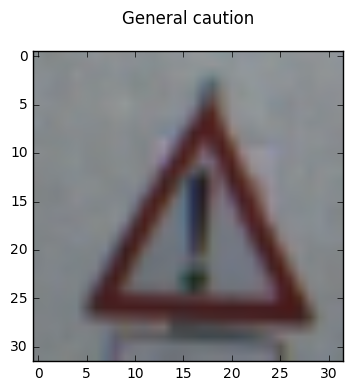

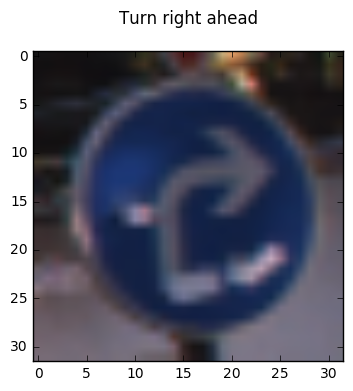

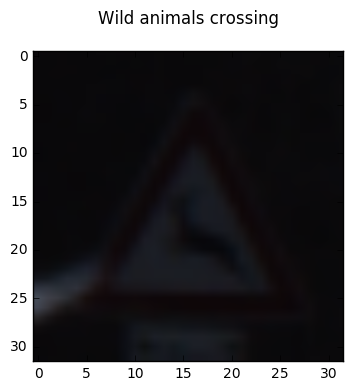

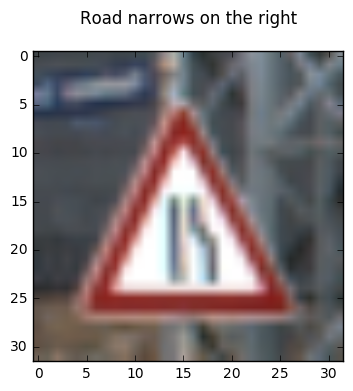

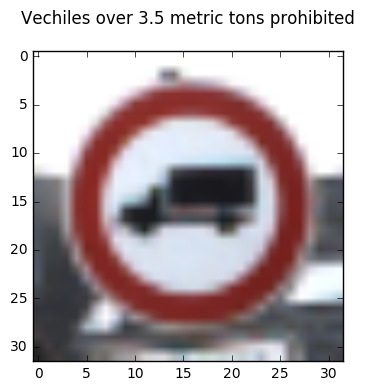

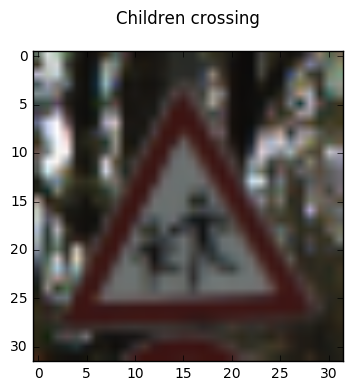

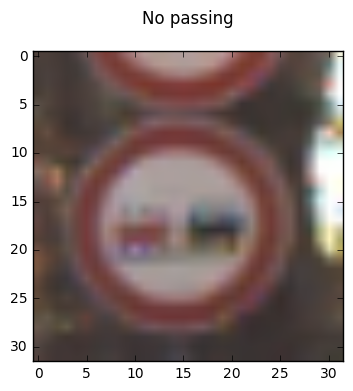

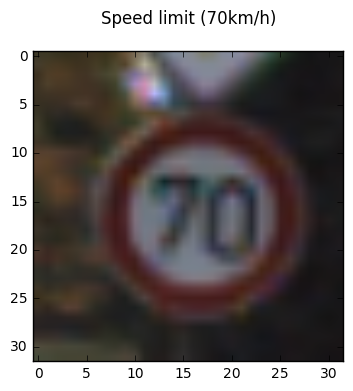

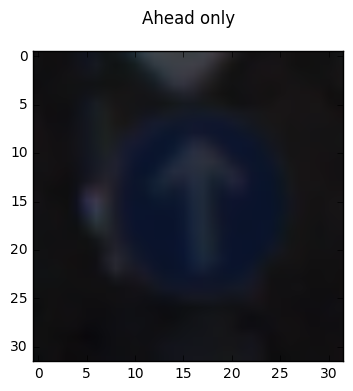

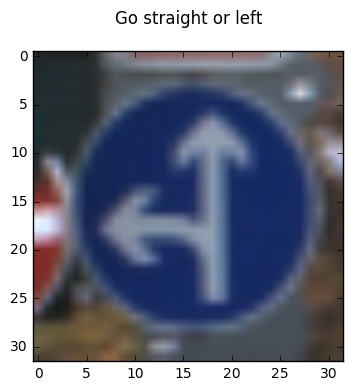

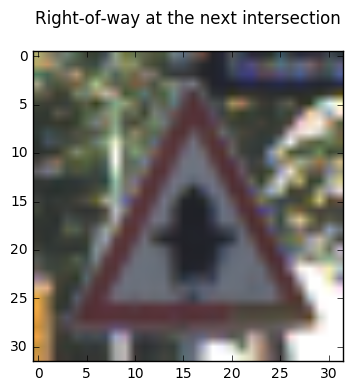

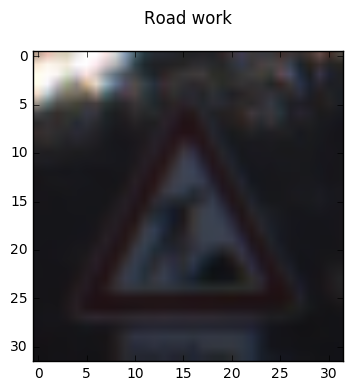

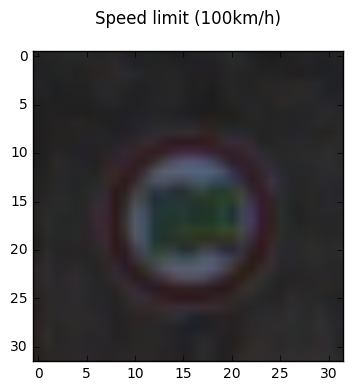

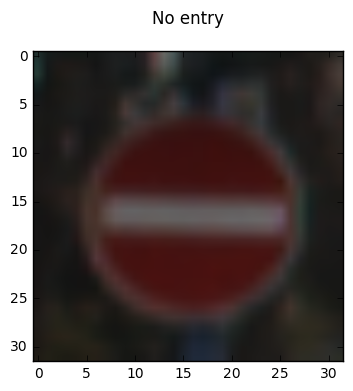

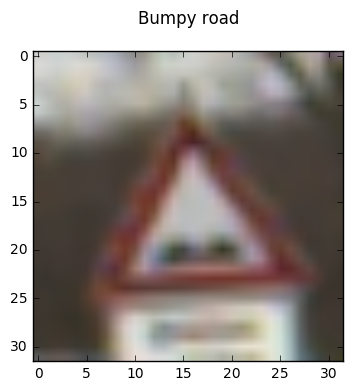

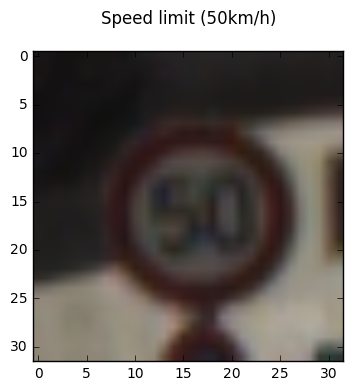

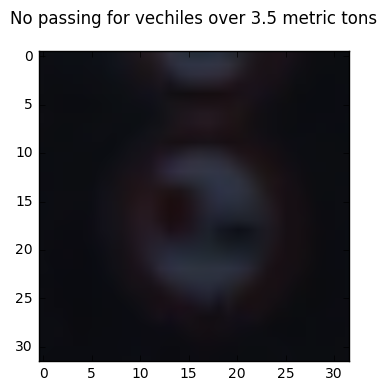

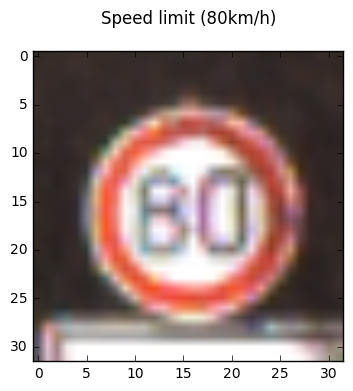

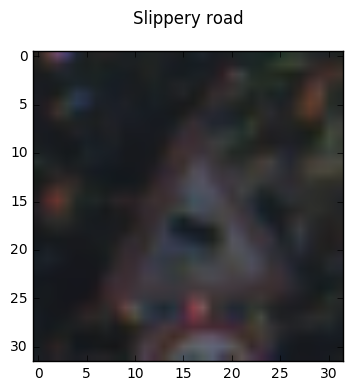

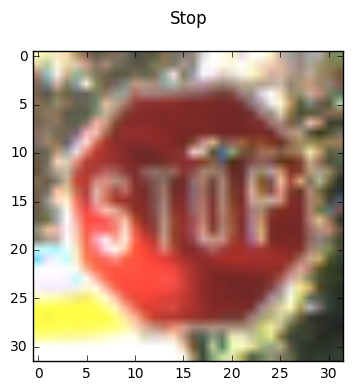

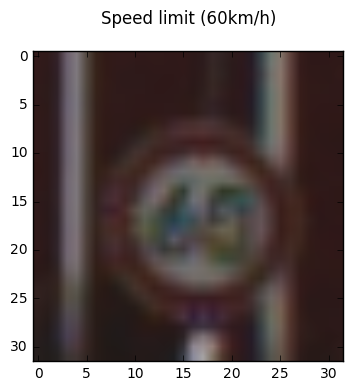

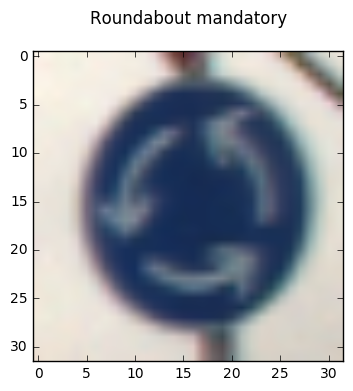

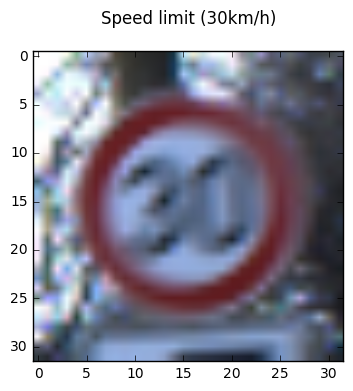

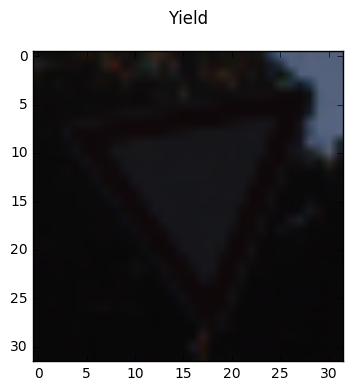

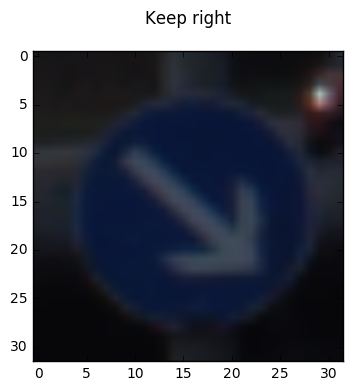

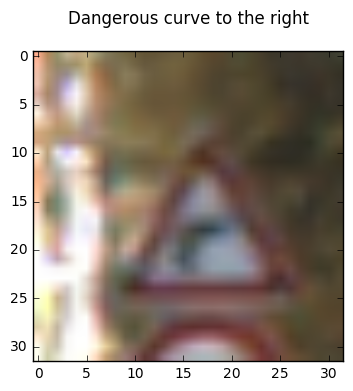

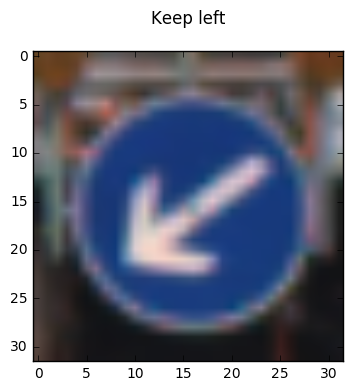

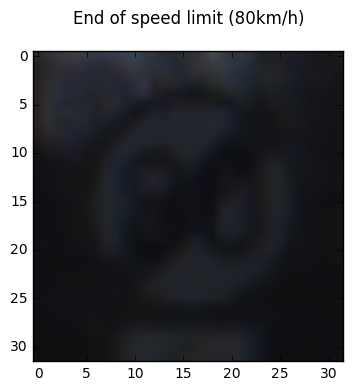

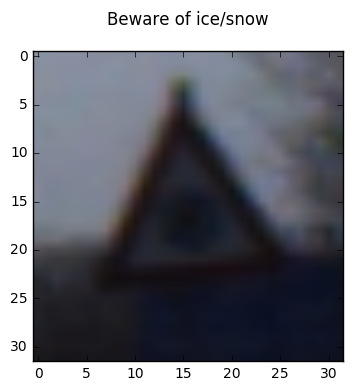

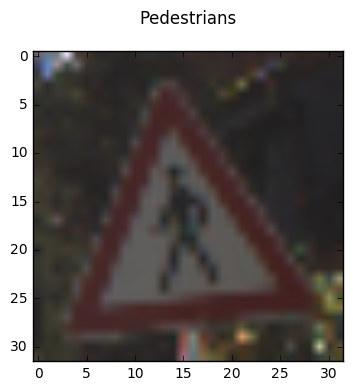

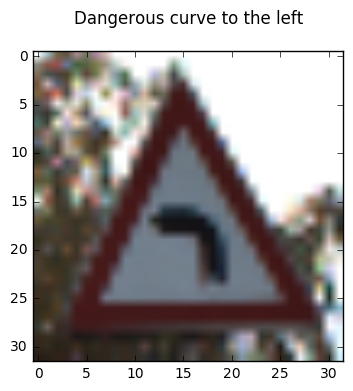

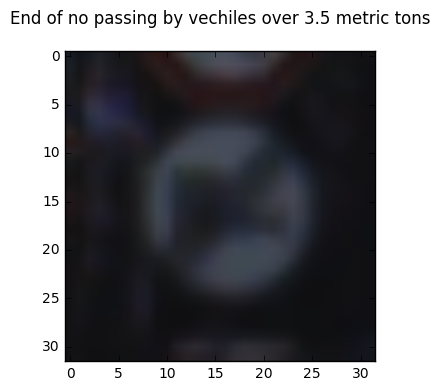

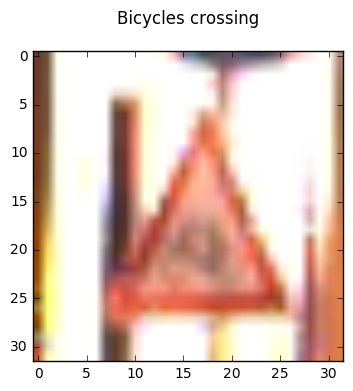

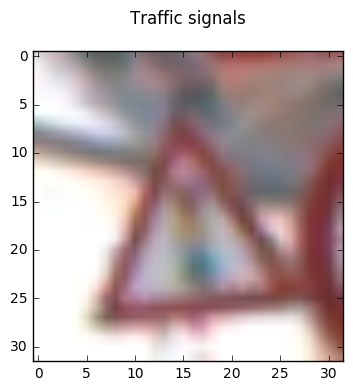

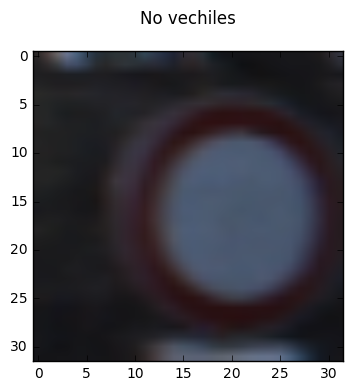

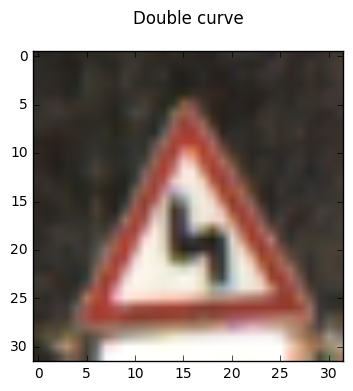

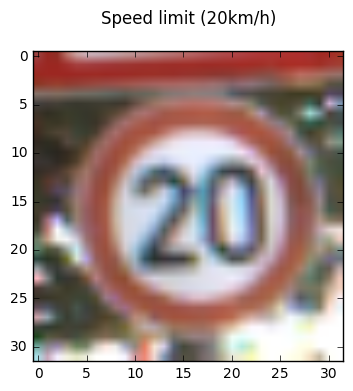

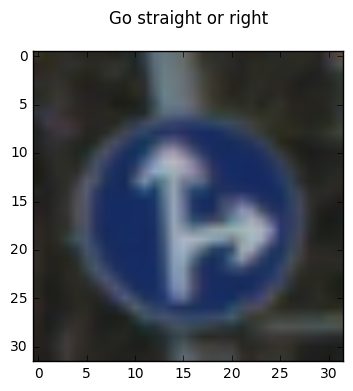

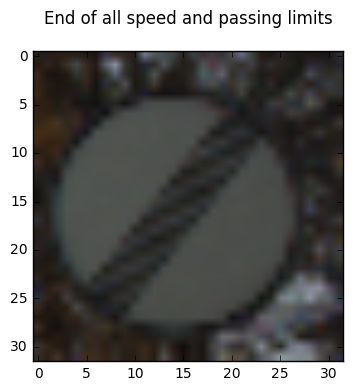

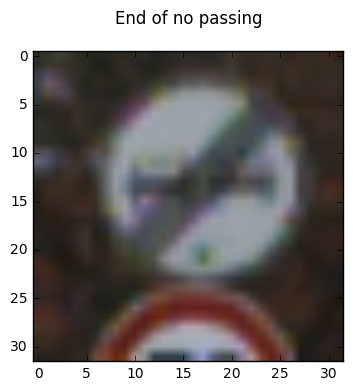

In [3]:
# Show a histogram of the number of training examples for each class.

# NOTES: Most classes have a good number of examples (>500) however some have
# very little. We should compare the results of those will smaller examples
# with those who have a large number of examples.
plt.hist(train_labels, n_classes)
plt.show()

# Show an example image from each class.

# NOTES: Looks like the signs are in a wide variety of lighting conditions and
# angles. 32x32 is fairly small, I think it would be hard to do this by hand.
known_labels = set()
for image, label in zip(X_train, train_labels):
    if label not in known_labels:
        known_labels.add(label)
        plt.imshow(image)
        plt.title(sign_names[label])
        plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

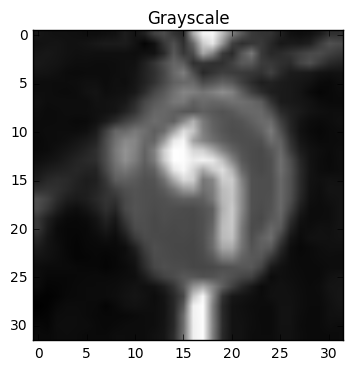

In [4]:
# Apply grayscale
X_train_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_train])
X_test_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_test])
plt.imshow(X_train_gray[0], cmap="gray")
plt.title("Grayscale")
plt.show()

# Normalize
train_features = (X_train_gray - 128.0) / 128.0
X_test_normalize = (X_test_gray - 128.0) / 128.0

### Question 1 

First I grayscaled the image. Most of the lighting and quality of the images of the are unreliable, so color may not be good features. Making it grayscaled means less features which means higher training speed and accuracy.

Then I normalized the input which makes it a bit easier to find initial weights for our network.

**Answer:**

In [5]:
# Split our test and validation set roughly in half.
valid_features = X_test_normalize[n_test//2:]
test_features = X_test_normalize[:n_test//2]

valid_labels = y_test[n_test//2:]
test_labels = y_test[:n_test//2]

### Question 2

Before doing anything, I randomized the order of the data in the training and test sets in the first cell above. I think split the test sets into two, one for test and one for validation.

**Answer:**

In [6]:
n_input = image_shape[0] * image_shape[1]
labels_count = n_classes

x = tf.placeholder(tf.float32, [None, 32, 32])
x_flat = tf.reshape(x, [-1, n_input])
y_ = tf.placeholder(tf.int32)
y_one_hot = tf.one_hot(y_, n_classes)

# Linear/Relu/Linear
n_hidden_layer = 256
weights = {
    'hidden_layer': tf.Variable(tf.truncated_normal([n_input, n_hidden_layer], stddev=0.01)),
    'out': tf.Variable(tf.truncated_normal([n_hidden_layer, n_classes], stddev=0.01))
}
biases = {
    'hidden_layer': tf.Variable(tf.zeros([n_hidden_layer])),
    'out': tf.Variable(tf.zeros([n_classes]))
}

# Hidden layer with RELU activation
layer_1 = tf.add(tf.matmul(x_flat, weights['hidden_layer']), biases['hidden_layer'])
layer_1 = tf.nn.relu(layer_1)

# Output layer with linear activation
logits = tf.matmul(layer_1, weights['out']) + biases['out']

# Cross entropy
prediction = tf.nn.softmax(logits)
cross_entropy = -tf.reduce_sum(y_one_hot * tf.log(tf.clip_by_value(prediction, 1e-10, 1.0)),
                               reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Feed dicts for training, validation, and test session
train_feed_dict = {x: train_features, y_: train_labels}
valid_feed_dict = {x: valid_features, y_: valid_labels}
test_feed_dict = {x: test_features, y_: test_labels}

### Question 3

First thing I did was reshape my inputs, so my features are flattened and my labels are one hot encoded. The architecture of my network could be described as a two-layer feed forward network. The first hidden layer is a dense layer with 256 hidden layers. From here the network is fed though a RELU function so it is no longer layer. It is then fed through a fully connected layer to finally get the logits. The logits are then fed though softmax and we use cross entropy as the loss function when training.

**Answer:**

Epoch 20/20: 100%|██████████| 3921/3921 [00:46<00:00, 84.43batches/s]


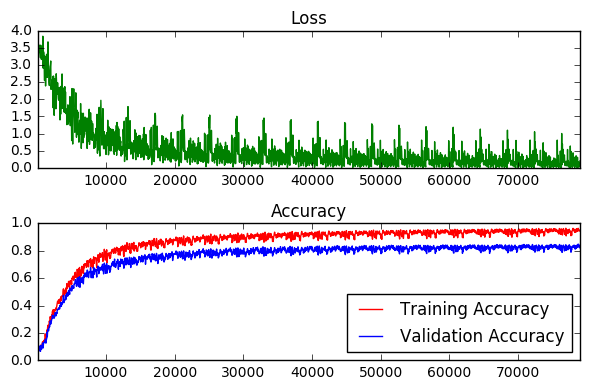

Validation accuracy at 0.8237529397010803


In [7]:
epochs = 20
batch_size = 10
learning_rate = 0.01

# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_one_hot, 1))

# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

# Initializing the variables
init = tf.initialize_all_variables()

session = tf.Session()
session.run(init)
batch_count = int(math.ceil(len(train_features)/batch_size))

for epoch_i in range(epochs):
        
    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        batch_features = train_features[batch_start:batch_start + batch_size]
        batch_labels = train_labels[batch_start:batch_start + batch_size]

        # Run optimizer and get loss
        _, l = session.run(
            [optimizer, loss],
            feed_dict={x: batch_features, y_: batch_labels})

        # Log every 50 batches
        if not batch_i % log_batch_step:
            # Calculate Training and Validation accuracy
            training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
            validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)

    # Check accuracy against Validation data
    validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

### Question 4

I used a gradient descent optimizer with a batch size of 10, epochs of 20, and learning rate of 0.01.

**Answer:**

### Question 5

I first did some the obvious preprocessing (randomizing, grayscaling, and normalizing). I then verified my input was correct. That means the features are flattened and the labels are one hot encoded.

From here I began setting up my network. I first did a simple linear function (wx + b) to make sure my network and testing was set up properly. From here I then did a more complicated network with two linear layers and a RELU layer. I attempted to do a CNN (based off of AlexNet) but my computer couldn't handle the computation and I had a lot of issues setting up a GPU instance on AWS.

With the more complicated network I then did paramter hypertuning. I got lucky with a good starting batch size of 10, and tried decreasing my linear rate along with increasing the epochs until I got a value I was happy with.

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

/home/ubuntu/anaconda3/envs/carnd/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


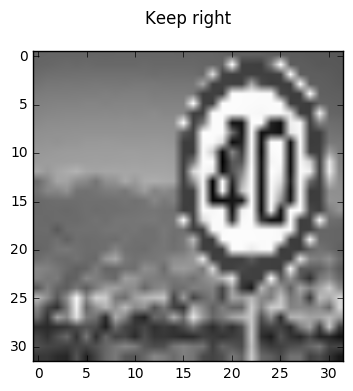

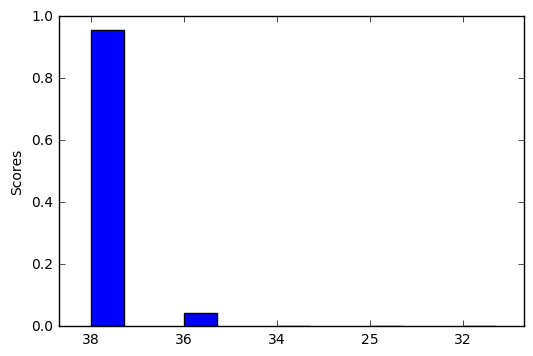

Top 5 Results

1: Keep right
 0.955730676651001
2: Go straight or right
 0.04394826665520668
3: Turn left ahead
 0.00013245614536572248
4: Road work
 9.763779962668195e-05
5: End of all speed and passing limits
 4.657556564779952e-05


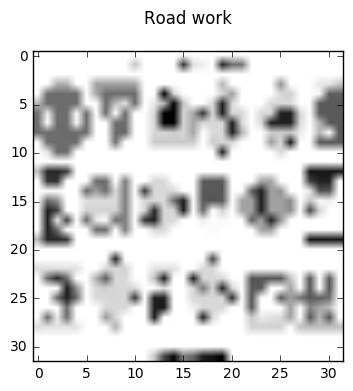

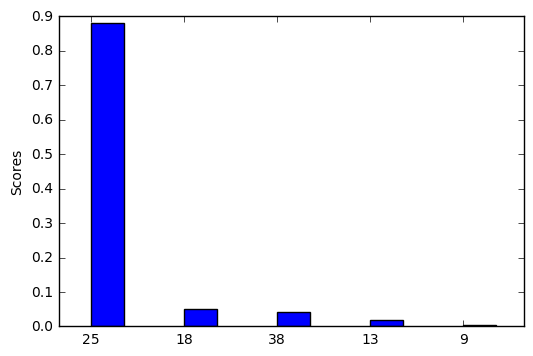

Top 5 Results

1: Road work
 0.8818778991699219
2: General caution
 0.05163788050413132
3: Keep right
 0.04255003109574318
4: Yield
 0.017282111570239067
5: No passing
 0.004406407009810209


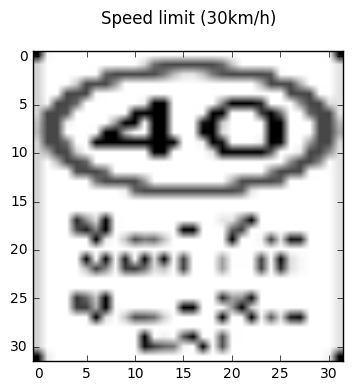

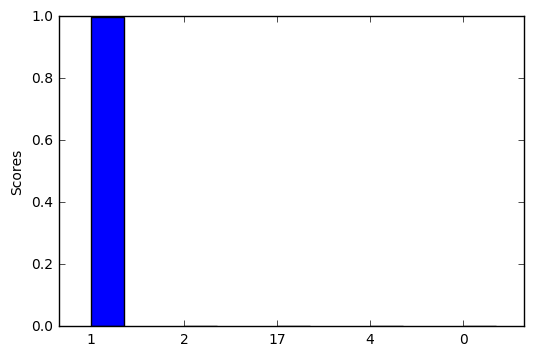

Top 5 Results

1: Speed limit (30km/h)
 0.9994971752166748
2: Speed limit (50km/h)
 0.00023558142129331827
3: No entry
 0.00010998232755810022
4: Speed limit (70km/h)
 0.0001007577302516438
5: Speed limit (20km/h)
 4.148586231167428e-05


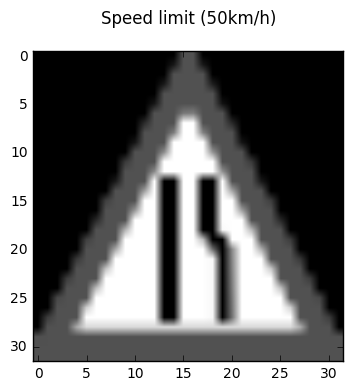

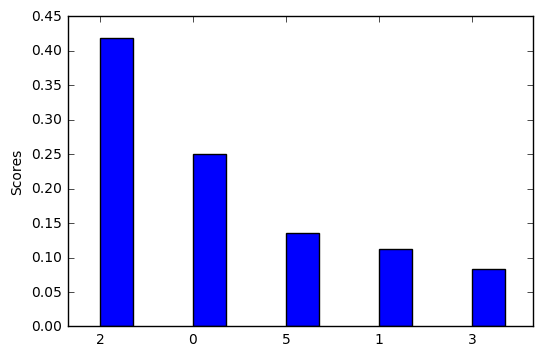

Top 5 Results

1: Speed limit (50km/h)
 0.41839122772216797
2: Speed limit (20km/h)
 0.2501446604728699
3: Speed limit (80km/h)
 0.13541190326213837
4: Speed limit (30km/h)
 0.11214784532785416
5: Speed limit (60km/h)
 0.0832403227686882


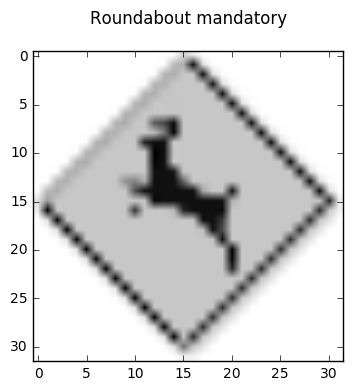

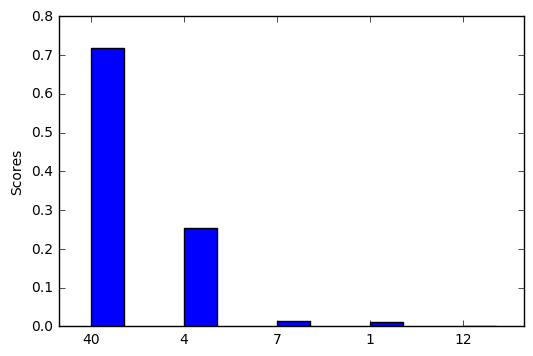

Top 5 Results

1: Roundabout mandatory
 0.7178465723991394
2: Speed limit (70km/h)
 0.25432726740837097
3: Speed limit (100km/h)
 0.014055623672902584
4: Speed limit (30km/h)
 0.011336982250213623
5: Priority road
 0.0021353017073124647


In [21]:
def preprocess_image(img_src):
    img = cv2.imread(img_src)
    img_resized = cv2.resize(img, (32, 32))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_normalized = (img_gray - 128.0) / 128.0
    return img_normalized

def classify_traffic_sign(preprocessed_img):
    classification = session.run(prediction, feed_dict={x: [preprocessed_img]})
    return sign_names[np.argmax(classification, 1)], np.argsort(-classification)[0][:5], -np.sort(-classification)[0][:5]

for i in range(1, 6):
    img_src = "sign-{}.png".format(i)
    img = preprocess_image(img_src)
    sign, top_predictions, classification = classify_traffic_sign(img)
    plt.title(sign)
    plt.imshow(img, cmap="gray")
    plt.show()
    width = 0.35
    plt.bar(np.arange(5) + width, classification, width)
    plt.ylabel('Scores')
    plt.xticks(np.arange(5) + width, (top_predictions[0],
                        top_predictions[1],
                        top_predictions[2],
                        top_predictions[3],
                        top_predictions[4]))
    plt.show()
    print("Top 5 Results\n")
    for i, p in enumerate(top_predictions):
        print("{}: {} {}".format(i + 1, sign_names[p], classification[i]))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
Some of the signs aren't in the original dataset, which would make it difficult to classify. One of them is actually
a collection of signs would would make it hard to predict just one, when there are actually several. In addition some
of the images have severe quality degradation when we compressed it to be a 32x32 image.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
The model would not do well on a live camera stream. For one the images are mch larger, and the model requires a 32x32
image, so we would need to compress it. To make the model do well for a live stream it would need to generalize it or
fit the model to the dimensions of the camera. In the test and training set the sign took up most of the image.

Another reason it might not work well, is that we don't do anything to localize the sign on the image. Some of the
signs require that we know where the sign actually is in the image.

Additionally it the image has more than one sign then we will only detect one sign. In order to combat this we would
need to be able to classify multiple things in a single image.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


The results of this can be viewed above. Some of our predictions are very certain (for example 99% certainty) however others are much less certain (70%)

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.